# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

## Types of Time Series Decomposition Techniques

### a) Additive Decomposition

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

### b) Multiplicative Decomposition

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

## Methods of Decomposition
### a) Moving Averages

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

### b) Seasonal Decomposition of Time Series

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

### c) Exponential Smoothing State Space Model

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

## Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import so4gp as sgp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sqlalchemy.sql import label
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import from local directory
import sys

sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI

In [2]:
# Hyperparameters

# f_path = "../datasets/air_quality1k.csv"
# f_path = "../datasets/rain_temp2013-2015.csv"
# f_path = ".../datasets/ndvi/average_evi_mak.csv"
f_path = "../datasets/ke_rain_data.csv"
eq = False
min_sup = 0.5
tgt_col = 2
min_rep = 0.5
num_cores = 4

In [3]:
data = pd.read_csv(f_path)
data.head()
# data[[' NRB (mm)']]

,Date (Jul-Sep),NRB (mm),KAK (mm),MAK (mm),WAJ (mm)
0,07-1981,75.66000,656.5199,9.150001,17.200000
1,07-1982,43.46000,637.1099,26.120000,50.640000
2,07-1983,63.65998,639.6699,4.140000,5.650000
3,07-1984,38.03000,450.8200,7.020000,2.929999
4,07-1985,46.43003,587.1400,7.889998,23.430000


In [4]:
tgp = TGradAMI(f_path, eq, min_sup, tgt_col, min_rep, num_cores)


Dataset Ok


In [5]:
# list_tgp, trans_data, time_data, eval_data = tgp.discover_tgp(parallel=True, eval_mode=True)
# eval_data

In [5]:
# tgp.data[:, tgp.attr_cols[0]]
tgp.data[:, tgp.time_cols[0]]

array(['07-1981', '07-1982', '07-1983', '07-1984', '07-1985', '07-1986',
       '07-1987', '07-1988', '07-1989', '07-1990', '07-1991', '07-1992',
       '07-1993', '07-1994', '07-1995', '07-1996', '07-1997', '07-1998',
       '07-1999', '07-2000', '07-2001', '07-2002', '07-2003', '07-2004',
       '07-2005', '07-2006', '07-2007', '07-2008', '07-2009', '07-2010',
       '07-2011', '07-2012', '07-2013', '07-2014', '07-2015', '07-2016',
       '07-2017', '07-2018', '07-2019', '07-2020', '07-2021', '07-2022'],
      dtype=object)

In [6]:
time_arr = tgp.data[:, tgp.time_cols[0]]
datetime_series = pd.to_datetime(time_arr, format='%m-%Y')
datetime_index = pd.DatetimeIndex(datetime_series)
#datetime_index

In [9]:
lst_ts = []
lst_titles = []
for col in tgp.attr_cols:
    ts = pd.Series(tgp.data[:, col].astype(float), index=datetime_index)
    lst_titles.append(tgp.titles[col][1].decode())
    lst_ts.append(ts)

['NRB (mm)', 'KAK (mm)', 'MAK (mm)', 'WAJ (mm)']

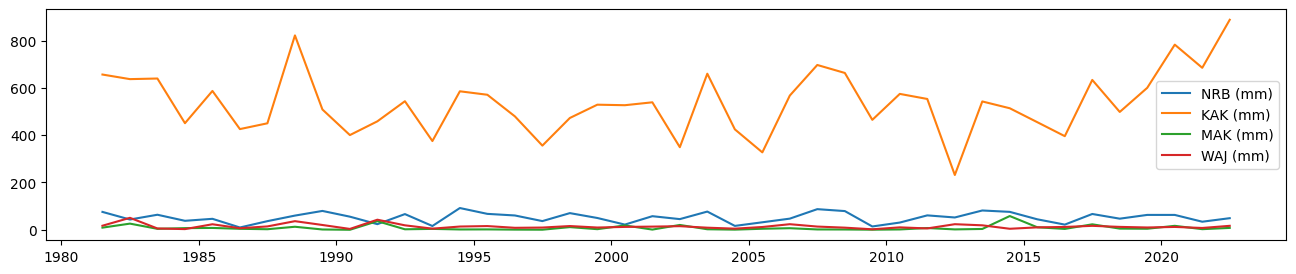

In [10]:
plt.figure(figsize=(16,3))
for i in range(len(lst_ts)):
    plt.plot(datetime_index, lst_ts[i], label=lst_titles[i])
plt.legend()

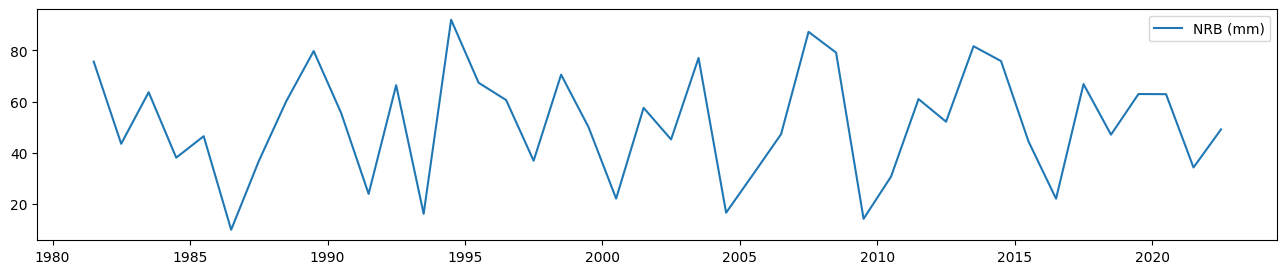

In [11]:
plt.figure(figsize=(16,3))
plt.plot(lst_ts[0], label=lst_titles[0])
plt.legend()

In [12]:
lst_compts = []
for ts in lst_ts:
    compt = seasonal_decompose(ts, model='additive')
    lst_compts.append(compt)


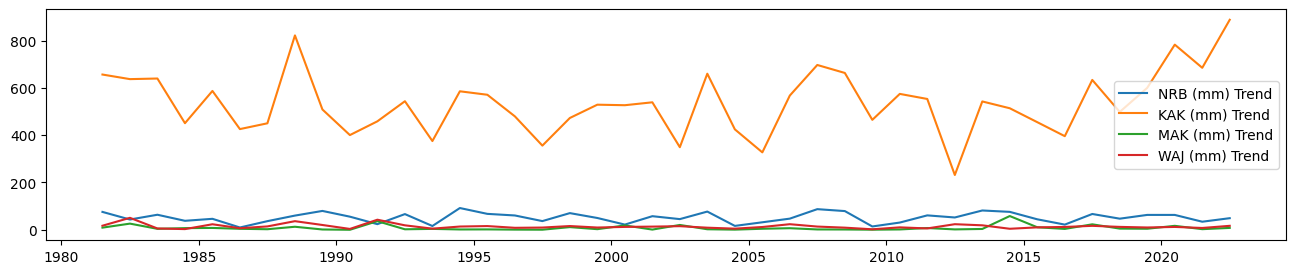

In [15]:
plt.figure(figsize=(16, 3))
for i in range(len(lst_compts)):
    plt.plot(datetime_index, lst_compts[i].trend, label=f"{lst_titles[i]} Trend")
plt.legend()

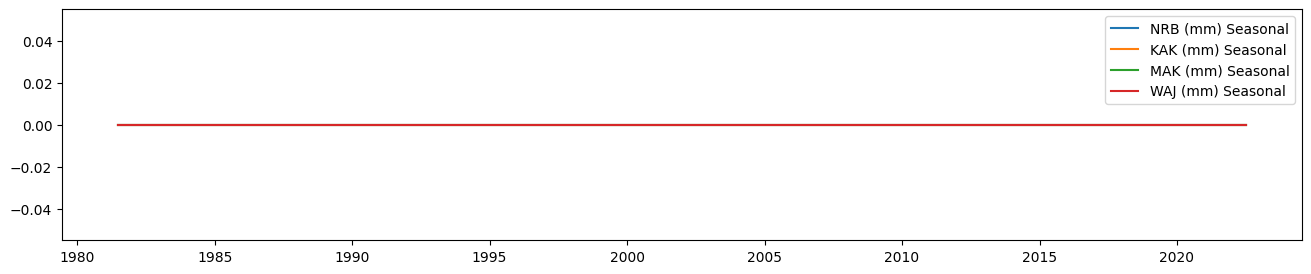

In [16]:
plt.figure(figsize=(16, 3))
for i in range(len(lst_compts)):
    plt.plot(datetime_index, lst_compts[i].seasonal, label=f"{lst_titles[i]} Seasonal")
plt.legend()

In [17]:
tgp.fit_bitmap()
v_bins = {}
for obj in tgp.valid_bins:
    adj_mat = obj[1]
    edge_lst = [(i,j) for i, row in enumerate(adj_mat) for j, val in enumerate(row) if (val)]
    gi = sgp.GI(obj[0][0], obj[0][1].decode())
    v_bins[gi.to_string()] = edge_lst

# tgp.valid_bins

In [18]:
#v_bins.items()
# v_bins['1+']
path1 = v_bins['1+']
path2 = v_bins['2+']
path3 = v_bins['3+']
path4 = v_bins['4+']

gr = [lst_ts[0].iloc[list(idx)] for idx in path1]
gr = pd.concat(gr)
gr.head()

1981-07-01    75.66000
1989-07-01    79.79001
1981-07-01    75.66000
1994-07-01    92.03001
1981-07-01    75.66000
dtype: float64

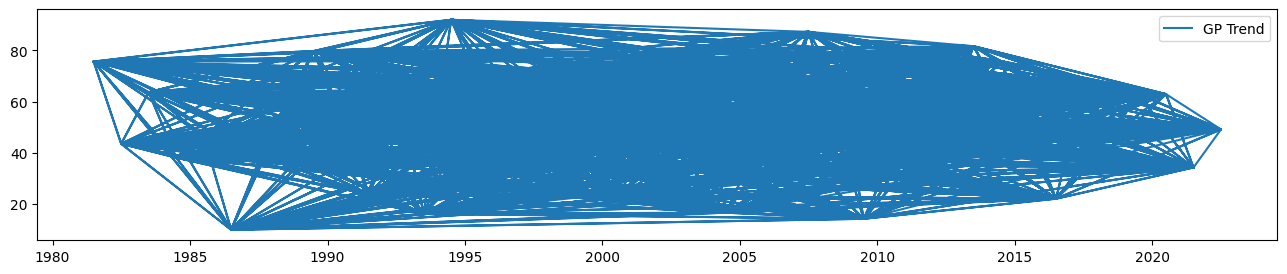

In [19]:
path1 = v_bins['1+']
plt.figure(figsize=(16, 3))
plt.plot(gr, label="GP Trend")
plt.legend()

In [31]:
# GP Decomposition
gp_comp1 = np.array(path1)
gp_comp1.shape

(861, 2)

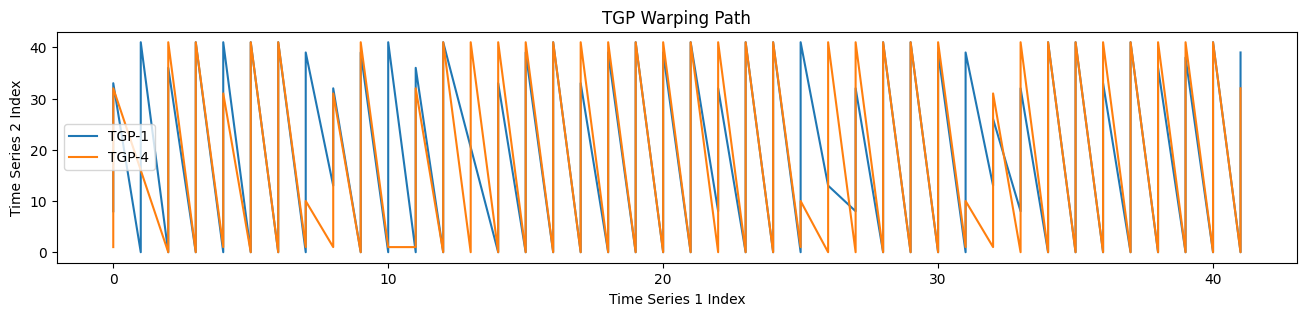

In [32]:
plt.figure(figsize=(16, 3))
plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="TGP-1")
#plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="TGP-2")
#plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="TGP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], label="TGP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('TGP Warping Path')
plt.legend()
plt.show()